In [2]:
from phantominator import shepp_logan
from matplotlib import pyplot as plt

import torch

from loguru import logger
import pathlib
from natsort import natsorted, ns

In [3]:
%load_ext autoreload
%autoreload 2

In [11]:
from quantization import *
from weight_compressors import *
from hyperparameter_sweeps import *
from benchmarkers import *

In [35]:
## Only run this if you're running an older version of Python (e.g., 3.6) + using Jupyter in dark mode!
############################################################################################
# SMALL_SIZE = 12
# MEDIUM_SIZE = 16
# BIGGER_SIZE = 18

# plt.rc('font', size=SMALL_SIZE)
# plt.rc('axes', titlesize=BIGGER_SIZE, titlecolor="white")  
# plt.rc('axes', labelsize=MEDIUM_SIZE, labelcolor="white")    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE, color="white")    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE, color="white")    # fontsize of the tick labels
############################################################################################

In [45]:
DEFAULT_DEVICE = "cuda:2"

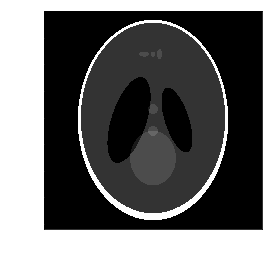

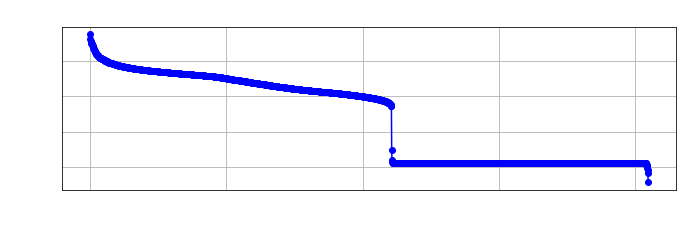

In [6]:
# Generate a phantominator matrix
X = torch.Tensor(shepp_logan(2048))
plt.imshow(X, cmap="gray", interpolation="nearest")
plt.show()

_, S, _ = torch.linalg.svd(X.float(), full_matrices=False)

# Plot the singular values
plt.figure(figsize=(11, 3))
plt.plot(S, marker='o', linestyle='-', color='b')
plt.title('Singular Values of Phantom(1024)', color="white")
plt.xlabel('Index', color="white")
plt.ylabel('Singular Value', color="white")
plt.yscale('log')
plt.grid(True)
plt.show()

In [37]:
def set_kwargs_lplr(kwargs, d):
    kwargs["k"] = int(kwargs["beta"] * d)
    kwargs["r1"] = int(kwargs["alpha"] * kwargs["k"])
    kwargs["r2"] = kwargs["r1"]
    kwargs["normalize_and_shift"] = False
    kwargs["log_errors"] = True
    del kwargs["alpha"]
    del kwargs["beta"]

def set_kwargs_loftq(kwargs, d):
    kwargs["r"] = int(kwargs["beta"] * X.shape[1])
    kwargs["normalize_and_shift"] = True
    kwargs["log_errors"] = True
    del kwargs["beta"]

def test_iterative_weight_compression(
    algorithm_kwargs = [{
        "alpha": 0.5,
        "beta": 0.4
    }], # list of dictionaries
    algorithm_fns = [alternating_mixed_lplr],
    algorithm_types = [AlgorithmType.LPLR],
    device = "cpu",
    X = None, # defaults to Shepp-Logan matrix
    plot_title = "Frobenius Norm Errors over Iterations"
):
    plot_colors = ["b", "r", "g", "c", "m", "k"]
    plot_markers = ["o", "X", "*"]
    # Set random seed for reproducibility
    torch.manual_seed(42)

    if X is None:
        # Generate a phantominator matrix
        X = torch.Tensor(shepp_logan(2048))
        print(f"Phantom shape: {X.shape[1]}")
    X = X.to(device)

    plt.figure(figsize=(11, 3))

    for i, param_set in enumerate(algorithm_kwargs):
        kwargs = param_set.copy()
        if algorithm_types[i] == AlgorithmType.LPLR:
            set_kwargs_lplr(kwargs, d=X.shape[1])
        elif algorithm_types[i] == AlgorithmType.LOFTQ:
            set_kwargs_loftq(kwargs, d=X.shape[1])

        # Call alternating_mixed_lplr and retrieve errors
        kwargs["X"] = X
        _, _, errors = algorithm_fns[i](**kwargs)
        
        fro_norm_X = torch.norm(X, p="fro").item()
        relative_errors = [error / fro_norm_X for error in errors]

        # Plot errors over iterations
        plt.plot(
            range(1, len(relative_errors) + 1),
            relative_errors,
            marker=plot_markers[(i // len(plot_colors)) % len(plot_markers)],
            linestyle="-",
            markersize=4,
            color=plot_colors[i % len(plot_colors)],
            label=f"Param Set {i+1}*")

    print("-"*80, "\n* Legend Key")
    for i, kwargs in enumerate(algorithm_kwargs):
        print(f"Param Set {i+1}: ", kwargs)
        print("\tusing function ", algorithm_fns[i])

    plt.title(plot_title)
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.yscale("log")
    plt.grid(True)
    plt.legend()
    plt.show()

Phantom shape: 2048


100%|██████████| 49/49 [00:04<00:00, 11.12it/s]


-------------------------------------------------------------------------------- 
* Legend Key
Param Set 1:  {'alpha': 0.5, 'beta': 0.4, 'B1': 8, 'B2': 8, 'quantization_fn': <function quantize at 0x7f796b1a8620>, 'iters': 50}
	using function  <function alternating_mixed_lplr at 0x7f793fb7e598>
Param Set 2:  {'alpha': 0.5, 'beta': 0.4, 'B1': 8, 'B2': 8, 'quantization_fn': <function quantize_nf at 0x7f796b14e7b8>, 'iters': 50}
	using function  <function alternating_mixed_lplr at 0x7f793fb7e598>


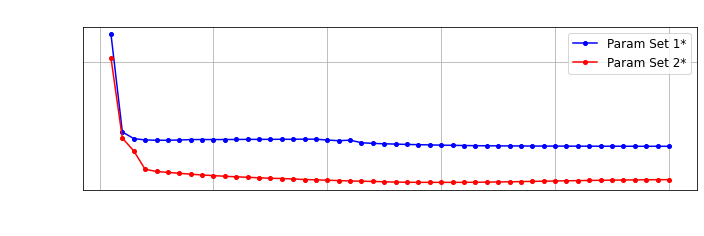

In [38]:
test_iterative_weight_compression(
    [
        {
            "alpha": 0.5, # Fraction of retained columns to be in full precision
            "beta": 0.4, # Fraction of columns to be retained
            "B1": 8,
            "B2": 8,
            "quantization_fn": quantize,
            "iters": 50
        },
        {
            "alpha": 0.5, # Fraction of retained columns to be in full precision
            "beta": 0.4, # Fraction of columns to be retained
            "B1": 8,
            "B2": 8,
            "quantization_fn": quantize_nf,
            "iters": 50
        }
    ],
    algorithm_fns=[
        alternating_mixed_lplr, alternating_mixed_lplr
    ],
    algorithm_types=[
        AlgorithmType.LPLR, AlgorithmType.LPLR
    ],
    plot_title="Frobenius Norm Errors over Iterations: LPLR",
    device=DEFAULT_DEVICE
)

Phantom shape: 2048


100%|██████████| 49/49 [00:02<00:00, 20.64it/s]


-------------------------------------------------------------------------------- 
* Legend Key
Param Set 1:  {'alpha': 0.5, 'beta': 0.31, 'B1': 8, 'B2': 8, 'BQ': 2, 'quantization_fn': <function quantize at 0x7f796b1a8620>, 'inner_iters': 50}
	using function  <function alternating_mixed_lplr_plus_q at 0x7f793fb2fe18>


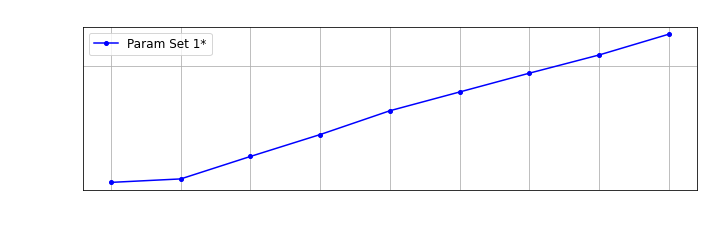

In [39]:
test_iterative_weight_compression(
    [
        {
            "alpha": 0.5, # Fraction of retained columns to be in full precision
            "beta": 0.31, # Same bitrate as the above cell
            "B1": 8,
            "B2": 8,
            "BQ": 2,
            "quantization_fn": quantize,
            "inner_iters": 50
        }
    ],
    algorithm_fns=[alternating_mixed_lplr_plus_q],
    algorithm_types=[AlgorithmType.LPLR],
    plot_title="Frobenius Norm Errors over Iterations: LoftQ w/ LPLR",
    device=DEFAULT_DEVICE
)

Phantom shape: 2048


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


-------------------------------------------------------------------------------- 
* Legend Key
Param Set 1:  {'B': 4, 'beta': 0.3}
	using function  <function loftq at 0x7f793fb2ff28>


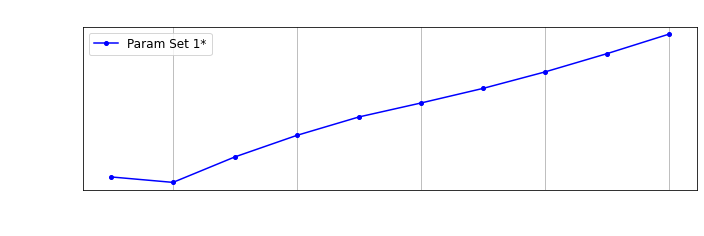

In [41]:
test_iterative_weight_compression(
    [
        {"B": 4, "beta": 0.3}
    ],
    algorithm_fns=[loftq],
    algorithm_types=[AlgorithmType.LOFTQ],
    plot_title="Frobenius Norm Errors over Iterations: LoftQ",
    device=DEFAULT_DEVICE
)

In [42]:
### Do some hyperparameter sweeps on the Shepp-Logan matrix
X = torch.Tensor(shepp_logan(2048)).to(DEFAULT_DEVICE)
average_bit_level = 3
budget = X.shape[0] * X.shape[1] * average_bit_level

mtxs, alpha, beta, B, error = lplr_sweep_alpha_and_B(
    X=X, budget=budget,
    kwarg_dict={"quantization_fn": quantize_nf, "iters":50, "normalize_and_shift": True},
    lplr_type=LplrType.ALTERNATING_MIXED,
    debug=True
)

--------------------------------------------------


2024-01-10 00:06:54.582 | INFO     | __main__:lplr_sweep_alpha:68 - B1=4, B2=4, alpha=0.0, beta=0.375
100%|██████████| 49/49 [00:05<00:00,  8.32it/s]
2024-01-10 00:07:01.205 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.10237274567831414


--------------------------------------------------


2024-01-10 00:07:01.206 | INFO     | __main__:lplr_sweep_alpha:68 - B1=4, B2=4, alpha=0.1, beta=0.28846154
100%|██████████| 49/49 [00:04<00:00, 11.39it/s]
2024-01-10 00:07:06.182 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.0724809779755017


--------------------------------------------------


2024-01-10 00:07:06.183 | INFO     | __main__:lplr_sweep_alpha:68 - B1=4, B2=4, alpha=0.2, beta=0.234375
100%|██████████| 49/49 [00:03<00:00, 15.09it/s]
2024-01-10 00:07:10.076 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.076938027373532


--------------------------------------------------


2024-01-10 00:07:10.077 | INFO     | __main__:lplr_sweep_alpha:68 - B1=4, B2=4, alpha=0.3, beta=0.19736842
100%|██████████| 49/49 [00:02<00:00, 17.86it/s]
2024-01-10 00:07:13.451 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.07591128183275273


--------------------------------------------------


2024-01-10 00:07:13.452 | INFO     | __main__:lplr_sweep_alpha:68 - B1=4, B2=4, alpha=0.4, beta=0.17045455
100%|██████████| 49/49 [00:02<00:00, 21.50it/s]
2024-01-10 00:07:16.356 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.08234977133083382


--------------------------------------------------


2024-01-10 00:07:16.357 | INFO     | __main__:lplr_sweep_alpha:68 - B1=4, B2=4, alpha=0.5, beta=0.15
100%|██████████| 49/49 [00:01<00:00, 25.31it/s]
2024-01-10 00:07:18.908 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.08488482924599484


--------------------------------------------------


2024-01-10 00:07:18.909 | INFO     | __main__:lplr_sweep_alpha:90 - [B1=4, B2=4]The best frobenius norm error was for alpha=0.1: 0.0724809779755017


--------------------------------------------------


2024-01-10 00:07:18.910 | INFO     | __main__:lplr_sweep_alpha:68 - B1=8, B2=8, alpha=0.0, beta=0.1875
100%|██████████| 49/49 [00:02<00:00, 16.88it/s]
2024-01-10 00:07:22.456 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.03630544976304997


--------------------------------------------------


2024-01-10 00:07:22.457 | INFO     | __main__:lplr_sweep_alpha:68 - B1=8, B2=8, alpha=0.1, beta=0.17045455
100%|██████████| 49/49 [00:02<00:00, 19.16it/s]
2024-01-10 00:07:25.647 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.04145882305411913


--------------------------------------------------


2024-01-10 00:07:25.648 | INFO     | __main__:lplr_sweep_alpha:68 - B1=8, B2=8, alpha=0.2, beta=0.15625
100%|██████████| 49/49 [00:02<00:00, 21.89it/s]
2024-01-10 00:07:28.507 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.0465036880104662


--------------------------------------------------


2024-01-10 00:07:28.508 | INFO     | __main__:lplr_sweep_alpha:68 - B1=8, B2=8, alpha=0.3, beta=0.14423077
100%|██████████| 49/49 [00:01<00:00, 24.71it/s]
2024-01-10 00:07:31.113 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.05081881497180889


--------------------------------------------------


2024-01-10 00:07:31.115 | INFO     | __main__:lplr_sweep_alpha:68 - B1=8, B2=8, alpha=0.4, beta=0.13392857
100%|██████████| 49/49 [00:01<00:00, 27.51it/s]
2024-01-10 00:07:33.512 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.05476416401411521


--------------------------------------------------


2024-01-10 00:07:33.513 | INFO     | __main__:lplr_sweep_alpha:68 - B1=8, B2=8, alpha=0.5, beta=0.125
100%|██████████| 49/49 [00:01<00:00, 29.99it/s]
2024-01-10 00:07:35.759 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.05842985986919176


--------------------------------------------------


2024-01-10 00:07:35.760 | INFO     | __main__:lplr_sweep_alpha:90 - [B1=8, B2=8]The best frobenius norm error was for alpha=0.0: 0.03630544976304997


--------------------------------------------------


2024-01-10 00:07:35.761 | INFO     | __main__:lplr_sweep_alpha_and_B:132 - The best frobenius norm error was for B=8, alpha=0.0: 0.03630544976304997


In [43]:
mtxs, alpha, beta, B, error = lplr_sweep_alpha_and_B(
    X=X, budget=budget,
    kwarg_dict={"quantization_fn": quantize_nf, "inner_iters":50, "outer_iters":5, "normalize_and_shift": True, "BQ": 2},
    lplr_type=LplrType.WITH_Q,
    debug=True
)

--------------------------------------------------


2024-01-10 00:08:13.789 | INFO     | __main__:lplr_sweep_alpha:68 - B1=4, B2=4, alpha=0.0, beta=0.125


100%|██████████| 49/49 [00:02<00:00, 24.16it/s]
2024-01-10 00:08:24.944 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.03542317096926012


--------------------------------------------------


2024-01-10 00:08:24.945 | INFO     | __main__:lplr_sweep_alpha:68 - B1=4, B2=4, alpha=0.1, beta=0.09615385
100%|██████████| 49/49 [00:01<00:00, 31.54it/s]
2024-01-10 00:08:34.054 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.033660055936151845


--------------------------------------------------


2024-01-10 00:08:34.055 | INFO     | __main__:lplr_sweep_alpha:68 - B1=4, B2=4, alpha=0.2, beta=0.078125
100%|██████████| 49/49 [00:01<00:00, 39.51it/s]
2024-01-10 00:08:41.927 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.03667451408630801


--------------------------------------------------


2024-01-10 00:08:41.928 | INFO     | __main__:lplr_sweep_alpha:68 - B1=4, B2=4, alpha=0.3, beta=0.06578947
100%|██████████| 49/49 [00:01<00:00, 46.80it/s]
2024-01-10 00:08:48.926 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.03445423679546778


--------------------------------------------------


2024-01-10 00:08:48.927 | INFO     | __main__:lplr_sweep_alpha:68 - B1=4, B2=4, alpha=0.4, beta=0.05681818
100%|██████████| 49/49 [00:00<00:00, 52.79it/s]
2024-01-10 00:08:55.486 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.03536474734352782


--------------------------------------------------


2024-01-10 00:08:55.487 | INFO     | __main__:lplr_sweep_alpha:68 - B1=4, B2=4, alpha=0.5, beta=0.05
100%|██████████| 49/49 [00:00<00:00, 61.83it/s]
2024-01-10 00:09:01.500 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.039276066959792334


--------------------------------------------------


2024-01-10 00:09:01.501 | INFO     | __main__:lplr_sweep_alpha:90 - [B1=4, B2=4]The best frobenius norm error was for alpha=0.1: 0.033660055936151845


--------------------------------------------------


2024-01-10 00:09:01.502 | INFO     | __main__:lplr_sweep_alpha:68 - B1=8, B2=8, alpha=0.0, beta=0.0625
100%|██████████| 49/49 [00:01<00:00, 42.33it/s]
2024-01-10 00:09:08.827 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.02313032526667879


--------------------------------------------------


2024-01-10 00:09:08.828 | INFO     | __main__:lplr_sweep_alpha:68 - B1=8, B2=8, alpha=0.1, beta=0.05681818
100%|██████████| 49/49 [00:01<00:00, 47.59it/s]
2024-01-10 00:09:15.730 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.02424138032374649


--------------------------------------------------


2024-01-10 00:09:15.731 | INFO     | __main__:lplr_sweep_alpha:68 - B1=8, B2=8, alpha=0.2, beta=0.05208333
100%|██████████| 49/49 [00:00<00:00, 53.52it/s]
2024-01-10 00:09:22.215 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.025382145134843243


--------------------------------------------------


2024-01-10 00:09:22.216 | INFO     | __main__:lplr_sweep_alpha:68 - B1=8, B2=8, alpha=0.3, beta=0.04807692
100%|██████████| 49/49 [00:00<00:00, 58.25it/s]
2024-01-10 00:09:28.354 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.02642767781316451


--------------------------------------------------


2024-01-10 00:09:28.355 | INFO     | __main__:lplr_sweep_alpha:68 - B1=8, B2=8, alpha=0.4, beta=0.04464286
100%|██████████| 49/49 [00:00<00:00, 63.10it/s]
2024-01-10 00:09:34.293 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.027458730420898615


--------------------------------------------------


2024-01-10 00:09:34.295 | INFO     | __main__:lplr_sweep_alpha:68 - B1=8, B2=8, alpha=0.5, beta=0.04166667
100%|██████████| 49/49 [00:00<00:00, 68.76it/s]
2024-01-10 00:09:39.865 | INFO     | __main__:lplr_sweep_alpha:77 - Frobenius norm error: 0.028427425765382063


--------------------------------------------------


2024-01-10 00:09:39.866 | INFO     | __main__:lplr_sweep_alpha:90 - [B1=8, B2=8]The best frobenius norm error was for alpha=0.0: 0.02313032526667879


--------------------------------------------------


2024-01-10 00:09:39.867 | INFO     | __main__:lplr_sweep_alpha_and_B:132 - The best frobenius norm error was for B=8, alpha=0.0: 0.02313032526667879


In [44]:
def compare_against_benchmarks_list(
    X_list:list = [],
    average_bit_level:int = 3,
    benchmarkers=[],
    reset_error_lists = True
):
    if reset_error_lists:
        for benchmarker in benchmarkers:
            benchmarker.reset_errors()

    for X in X_list:
        n, d = X.size()
        budget = n*d*average_bit_level

        for benchmarker in benchmarkers:
            benchmarker.run(X, budget)
            
    for benchmarker in benchmarkers:
        print(f"{benchmarker.label}: {benchmarker.errors}")

In [51]:
def compare_against_benchmarkers_model(
    model_directory:pathlib.Path,
    average_bit_level:int = 3,
    benchmarkers:list = [],
    reset_error_lists:bool = False,
    device="cpu",
    layer_limit:int = -1, # Limits the number of weight matrices used
                          # for benchmarking (mainly for debugging purposes).
                          # -1 means no limit.
    max_num_cols:int = -1 # for debugging
):
    if reset_error_lists:
        for benchmarker in benchmarkers:
            benchmarker.reset_errors()
            
    model_files = natsorted(model_directory.glob("*.bin"), alg=ns.IC)
    layer_count = 0

    for f in model_files:
        layer_set = torch.load(f, map_location=device)
        for name, X in layer_set.items():
            if X.dim() != 2:
                continue
            logger.info(f"{name}: {X.shape}")
            if X.shape[0] < X.shape[1]:
                X = X.T
            n, d = X.size()
            assert n >=d

            if max_num_cols > 0 and n > max_num_cols:
                logger.info("Layer larger than maximum size specified, skipping.")
                break

            budget = n*d*average_bit_level

            X = X.float()

            layer_count += 1
            if layer_limit > 0 and layer_count > layer_limit:
                logger.info("Reached layer limit, exiting.")
                return
            
            for benchmarker in benchmarkers:
                benchmarker.run(X, budget)

In [52]:
benchmarkers = [
        LplrBenchmarker(
            LplrType.ALTERNATING_MIXED,
            {
                "quantization_fn": quantize_nf,
                "iters": 50,
                "alpha_start": 0,
                "alpha_stop": 0.5,
                "alpha_step": 0.1,
                "prune": True
            }
        ),
        LplrBenchmarker(
            LplrType.DIRECT_SVD,
            {
                "quantization_fn": quantize_nf,
                "alpha_start": 0,
                "alpha_stop": 0.5,
                "alpha_step": 0.1,
                "prune": True
            }
        ),
        LplrBenchmarker(
            LplrType.WITH_Q,
            {
                "quantization_fn": quantize_nf,
                "alpha_start": 0,
                "alpha_stop": 0.5,
                "alpha_step": 0.1,
                "prune": True,
                "inner_iters": 30,
                "outer_iters": 5,
                "BQ": 2
            }
        ),
        FullQuantBenchmarker(
            {
                "quantization_fn": quantize,
            },
            label="Uniform Quantization"
        ),
        FullQuantBenchmarker(
            {
                "quantization_fn": quantize_nf
            },
            label="Normal Float Quantization"
        ),
        LoftqBenchmarker(
            {
                "quantization_fn": quantize_nf,
                "B": 2,
                "iters": 10
            },
            label="LoftQ (B=2)"
        ),
    ]

In [53]:
model_directory = pathlib.Path("/mnt/sda2/models/Mistral-7B-v0.1-bf16-sharded/")
compare_against_benchmarkers_model(
    model_directory=model_directory,
    average_bit_level=3,
    benchmarkers=benchmarkers,
    reset_error_lists=True,
    device=DEFAULT_DEVICE,
    layer_limit=5,
    max_num_cols=15000
)

2024-01-10 11:15:23.901 | INFO     | __main__:compare_against_benchmarkers_model:24 - model.embed_tokens.weight: torch.Size([32000, 4096])
2024-01-10 11:15:23.902 | INFO     | __main__:compare_against_benchmarkers_model:31 - Layer larger than maximum size specified, skipping.
2024-01-10 11:15:34.068 | INFO     | __main__:compare_against_benchmarkers_model:24 - model.layers.3.mlp.down_proj.weight: torch.Size([4096, 14336])
 65%|██████▌   | 32/49 [00:56<00:29,  1.76s/it]


KeyboardInterrupt: 

In [8]:
def absmax_quantize_int8(X: torch.Tensor) -> tuple[torch.Tensor, torch.float16]:
    """Quantize each float16/32 data type to int8 and return the maximum value in float16"""
    scale = X.abs().max().item() / 127.0
    int8_tensor = (X / scale).round().to(torch.int8)
    return scale, int8_tensor

In [9]:
def absmax_dequantize_int8(Xq: torch.Tensor, scale: torch.float16) -> torch.Tensor:
    """Dequantize int8 data type to float16/32"""
    return Xq.to(torch.float16) * scale